config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Map:   0%|          | 0/36944 [00:00<?, ? examples/s]

Map:   0%|          | 0/4618 [00:00<?, ? examples/s]

Map:   0%|          | 0/4619 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.777200,0.292430,0.942616
2,0.436900,0.282792,0.954309
3,0.000000,0.319672,0.959506


Model saved to ./fine_tuned_gpt_neo_3_epochs


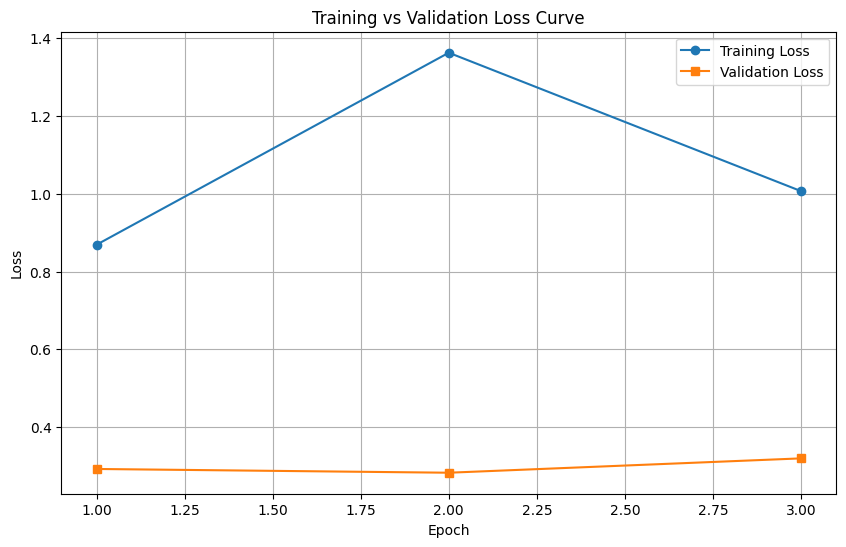

Evaluation Results: {'eval_loss': 0.24991892278194427, 'eval_accuracy': 0.9616800173197662, 'eval_runtime': 124.4642, 'eval_samples_per_second': 37.111, 'eval_steps_per_second': 18.56, 'epoch': 3.0}
Classification Report:
               precision    recall  f1-score   support

Human-written       0.95      0.96      0.96      1539
 AI-generated       0.98      0.99      0.99      1540
  Paraphrased       0.95      0.93      0.94      1540

     accuracy                           0.96      4619
    macro avg       0.96      0.96      0.96      4619
 weighted avg       0.96      0.96      0.96      4619



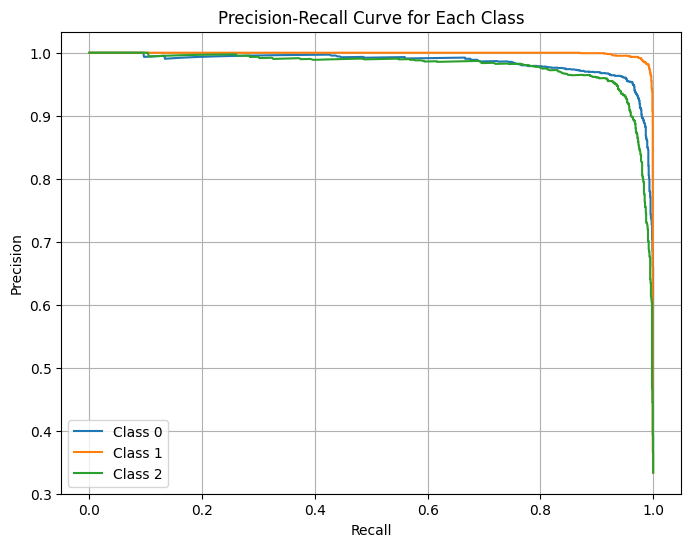

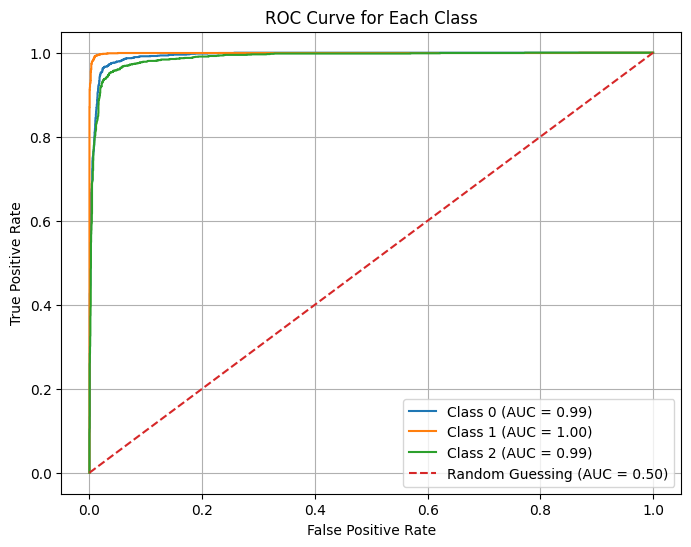

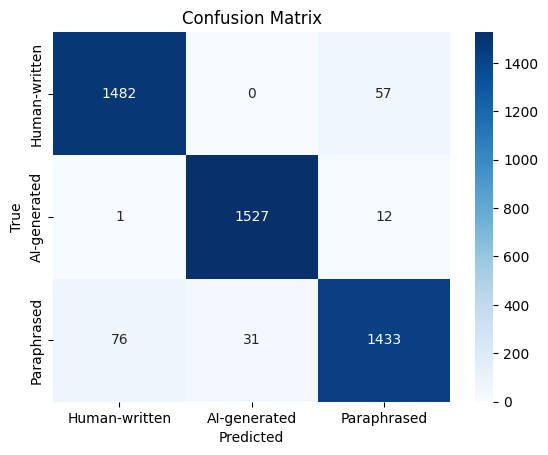

In [1]:
import torch
from transformers import AutoModelForSequenceClassification, GPT2Tokenizer, Trainer, TrainingArguments, DataCollatorWithPadding, AutoConfig
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
import seaborn as sns

# Load GPT-Neo model configuration with additional dropout
model_name = "EleutherAI/gpt-neo-125M"
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=3,  # Number of classes: Human-written, AI-generated, Paraphrased
    hidden_dropout_prob=0.2,  # Dropout for hidden layers
    attention_probs_dropout_prob=0.2  # Dropout for attention layers
)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Add padding token to tokenizer and model
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

# Load datasets
ai_data = pd.read_csv('/kaggle/input/custom-dataset/ai.csv')
human_data = pd.read_csv('/kaggle/input/custom-dataset/human.csv')
paraphrased_data = pd.read_csv('/kaggle/input/custom-dataset/paraphrased.csv')

# Assign labels and combine datasets
ai_data['label'] = 1  # AI-generated
human_data['label'] = 0  # Human-written
paraphrased_data['label'] = 2  # Paraphrased
all_data = pd.concat([ai_data, human_data, paraphrased_data]).sample(frac=1).reset_index(drop=True)

# Stratified split
def stratified_split(data, train_ratio=0.8, val_ratio=0.1):
    train_data, temp_data = train_test_split(
        data, stratify=data["label"], test_size=1 - train_ratio, random_state=42
    )
    val_data, test_data = train_test_split(
        temp_data, stratify=temp_data["label"], test_size=val_ratio / (1 - train_ratio), random_state=42
    )
    return train_data, val_data, test_data

train_data, validation_data, test_data = stratified_split(all_data)

# Tokenization function
def tokenize_function(examples):
    return {
        **tokenizer(
            examples["abstract"], truncation=True, padding="max_length", max_length=512
        ),
        "labels": examples["label"]
    }

# Prepare datasets for training
train_dataset = Dataset.from_pandas(train_data).map(tokenize_function, batched=True)
validation_dataset = Dataset.from_pandas(validation_data).map(tokenize_function, batched=True)
test_dataset = Dataset.from_pandas(test_data).map(tokenize_function, batched=True)

# Training arguments with learning rate scheduler
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    report_to="none",
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    lr_scheduler_type="linear",
    warmup_steps=500
)

# Metrics for evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=-1)
    accuracy = accuracy_score(labels, preds)
    return {"accuracy": accuracy}

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
training_logs = trainer.train()

# Save the fine-tuned model and tokenizer
output_dir = "./fine_tuned_gpt_neo_3_epochs"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

# Extract training and validation loss
logs = trainer.state.log_history
training_loss = [log["loss"] for log in logs if "loss" in log]
validation_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]
epochs = range(1, len(validation_loss) + 1)

# Plot Training vs Validation Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss[:len(validation_loss)], label="Training Loss", marker='o')
plt.plot(epochs, validation_loss, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Evaluate on test set
eval_results = trainer.evaluate(test_dataset)
print("Evaluation Results:", eval_results)

# Predict and calculate metrics
test_labels = test_data["label"].values
predictions = []
all_logits = []

for abstract in test_data["abstract"]:
    inputs = tokenizer(abstract, return_tensors="pt", padding=True, truncation=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    predictions.append(predicted_class)
    all_logits.append(logits.cpu().numpy())

# Convert all_logits to numpy array
all_logits = np.concatenate(all_logits, axis=0)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=['Human-written', 'AI-generated', 'Paraphrased']))

# Precision-Recall Curves
plt.figure(figsize=(8, 6))
plt.title("Precision-Recall Curve for Each Class")
for i, class_name in enumerate(['Class 0', 'Class 1', 'Class 2']):
    y_true = (test_labels == i).astype(int)
    y_scores = all_logits[:, i]`
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label=f"{class_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

# ROC Curves
plt.figure(figsize=(8, 6))
plt.title("ROC Curve for Each Class")
for i, class_name in enumerate(['Class 0', 'Class 1', 'Class 2']):
    y_true = (test_labels == i).astype(int)
    y_scores = all_logits[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Guessing (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human-written', 'AI-generated', 'Paraphrased'],
            yticklabels=['Human-written', 'AI-generated', 'Paraphrased'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
import torch
from transformers import AutoModelForSequenceClassification, GPT2Tokenizer
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Path to checkpoint
checkpoint_dir = "./results/checkpoint-55416"  # Replace with your checkpoint directory

# Load the fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_dir)

# Load the tokenizer
try:
    tokenizer = GPT2Tokenizer.from_pretrained(checkpoint_dir)  # Try to load from checkpoint
except OSError:
    tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M")  # Load from source
    tokenizer.pad_token = tokenizer.eos_token
    print("Tokenizer loaded from the original source.")

print("Model and tokenizer loaded successfully!")

Tokenizer loaded from the original source.
Model and tokenizer loaded successfully!


**Define Prompts and Inputs**

In [11]:
# Label map
label_map = {0: "Human-written", 1: "AI-generated", 2: "Paraphrased"}

# Prompts for classification
prompts = [
    "Is this text written by a human, generated by AI, or paraphrased from an existing source? Please identify any markers or patterns that support your answer.",
    "What linguistic, stylistic, or structural features in this text suggest it is human-written, AI-generated, or paraphrased? Highlight specific elements like tone, coherence, or originality.",
    "Does this text exhibit common features of human authorship, AI generation (like GPT), or paraphrasing from another work? Consider factors like vocabulary, sentence complexity, and context repetition.",
]

# Test data (texts and corresponding ground-truth labels)
texts = [
    "For this task, the electra-base-discriminator model was used as the baseline, as it has a pre-trained architecture which has been further fine-tuned for a multi-class classification task. The three output labels refer to the type of abstracts generated; human-written, AI-generated, and paraphrased abstracts. If the ELECTRA baseline model is assessed on the dataset it was trained on, it performs well, with an accuracy of 33%",
    "I remember visiting the Grand Canyon as a child. The sheer size of it was overwhelming, and I felt a mix of awe and fear standing at the edge. My dad held my hand tightly, reminding me of the safety rules as we took in the breathtaking view.",
    "The Grand Canyon is a very large and impressive geological formation. It attracts many tourists every year. People who visit the Grand Canyon often feel amazed by its size and beauty. Safety is important when visiting, and it is advised to follow all safety rules."
]

ground_truth_labels = [0, 1, 2]  # Replace with ground-truth labels corresponding to the texts


**Direct Prompting**

Classification Report:
               precision    recall  f1-score   support

Human-written       0.33      1.00      0.50         1
 AI-generated       0.00      0.00      0.00         1
  Paraphrased       0.00      0.00      0.00         1

     accuracy                           0.33         3
    macro avg       0.11      0.33      0.17         3
 weighted avg       0.11      0.33      0.17         3



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


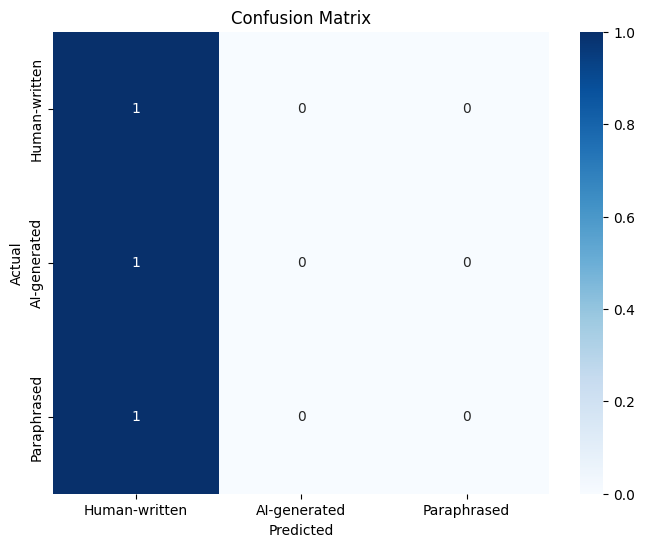

In [12]:
# Predictions
predictions = []

for prompt, text in zip(prompts, texts):
    full_prompt = f"{prompt}\n\nText: {text}\nAnswer:"

    # Tokenize input
    inputs = tokenizer(full_prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}

    # Generate predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    predictions.append(prediction)

# Classification report
print("Classification Report:")
print(classification_report(ground_truth_labels, predictions, target_names=label_map.values()))

# Confusion matrix
cm = confusion_matrix(ground_truth_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
for prompt, text in zip(prompts, texts):
    full_prompt = f"{prompt}\n\nText: {text}\nAnswer:"

    # Tokenize input
    inputs = tokenizer(full_prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}

    # Generate predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    predictions.append(prediction)

    # Print logits for debugging
    print(f"Logits for text: {text}")
    print(logits)
    print(f"Predicted label: {label_map[prediction]}")


Logits for text: For this task, the electra-base-discriminator model was used as the baseline, as it has a pre-trained architecture which has been further fine-tuned for a multi-class classification task. The three output labels refer to the type of abstracts generated; human-written, AI-generated, and paraphrased abstracts. If the ELECTRA baseline model is assessed on the dataset it was trained on, it performs well, with an accuracy of 33%
tensor([[  7.6464, -10.0662,  -2.4867]])
Predicted label: Human-written
Logits for text: I remember visiting the Grand Canyon as a child. The sheer size of it was overwhelming, and I felt a mix of awe and fear standing at the edge. My dad held my hand tightly, reminding me of the safety rules as we took in the breathtaking view.
tensor([[  3.5786, -12.3559,   1.9024]])
Predicted label: Human-written
Logits for text: The Grand Canyon is a very large and impressive geological formation. It attracts many tourists every year. People who visit the Grand 

**Few-Shot Learning with COT**

In [33]:
# Few-shot examples for COT
few_shot_examples = [
    {"input": "This text flows naturally and is coherent. It is likely written by a human.", "label": "Human-written"},
    {"input": "This sentence is repetitive and follows structured patterns, likely AI-generated.", "label": "AI-generated"},
    {"input": "This text retains the original meaning but uses different phrasing. It is paraphrased.", "label": "Paraphrased"},
]

# Few-shot COT Prompting
for text in texts:
    few_shot_prompt = "\n".join([f"Input: {ex['input']}\nAnswer: {ex['label']}" for ex in few_shot_examples])
    cot_prompt = f"{few_shot_prompt}\n\nInput: {text}\nAnalyze step-by-step: Is this text human-written, AI-generated, or paraphrased?\nAnswer:"
    
    inputs = tokenizer(cot_prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()
    
    label_map = {0: "Human-written", 1: "AI-generated", 2: "Paraphrased"}
    print(f"Text: {text}\nFew-Shot COT Prediction: {label_map[prediction]}\n")


Text: For this task, the electra-base-discriminator model was used as the baseline, as it has a pre-trained architecture which has been further fine-tuned for a multi-class classification task. The three output labels refer to the type of abstracts generated; human-written, AI-generated, and paraphrased abstracts. If the ELECTRA baseline model is assessed on the dataset it was trained on, it performs well, with an accuracy of 33%
Few-Shot COT Prediction: Human-written



**Self-Consistency with COT**

In [34]:
from collections import Counter

# Self-Consistency COT
for text in texts:
    predictions = []
    for _ in range(5):  # Generate multiple predictions
        cot_prompt = (
            f"Input: {text}\n"
            "Step 1: Analyze linguistic features such as coherence, tone, and originality.\n"
            "Step 2: Consider if the text is repetitive or follows unnatural phrasing.\n"
            "Step 3: Conclude whether it is human-written, AI-generated, or paraphrased.\nAnswer:"
        )

        inputs = tokenizer(cot_prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(model.device) for key, val in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            prediction = torch.argmax(logits, dim=-1).item()
            predictions.append(prediction)

    # Majority vote
    most_common_prediction = Counter(predictions).most_common(1)[0][0]
    label_map = {0: "Human-written", 1: "AI-generated", 2: "Paraphrased"}
    print(f"Text: {text}\nSelf-Consistency Prediction: {label_map[most_common_prediction]}\n")


Text: For this task, the electra-base-discriminator model was used as the baseline, as it has a pre-trained architecture which has been further fine-tuned for a multi-class classification task. The three output labels refer to the type of abstracts generated; human-written, AI-generated, and paraphrased abstracts. If the ELECTRA baseline model is assessed on the dataset it was trained on, it performs well, with an accuracy of 33%
Self-Consistency Prediction: Human-written



**Least-to-Most (L2M) Prompting**

In [35]:
# Least-to-Most (L2M) Prompting
for text in texts:
    l2m_prompt = (
        f"Text: {text}\n"
        "Step 1: Determine if the text is human-like or machine-like.\n"
        "Step 2: If it is machine-like, decide whether it is AI-generated or paraphrased.\n"
        "Step 3: Provide a detailed analysis and conclude with your final answer.\nAnswer:"
    )
    
    inputs = tokenizer(l2m_prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(model.device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    label_map = {0: "Human-written", 1: "AI-generated", 2: "Paraphrased"}
    print(f"Text: {text}\nL2M Prediction: {label_map[prediction]}\n")


Text: For this task, the electra-base-discriminator model was used as the baseline, as it has a pre-trained architecture which has been further fine-tuned for a multi-class classification task. The three output labels refer to the type of abstracts generated; human-written, AI-generated, and paraphrased abstracts. If the ELECTRA baseline model is assessed on the dataset it was trained on, it performs well, with an accuracy of 33%
L2M Prediction: Human-written

